<a href="https://colab.research.google.com/github/danielsoy/ALOCC-CVPR2018/blob/master/hazelnut_PaDiM_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Paper: https://arxiv.org/pdf/2011.08785.pdf

In [ ]:
%pip install dotmap -q

#### Explain dataset directory structure

Here, we download 2 datasets: **MVTec-AD** (contains many different objects) and **Transistor** dataset for testing purpose

**Transistor dataset should be replaced by your custom dataset.**

Your custom dataset should have the following order:

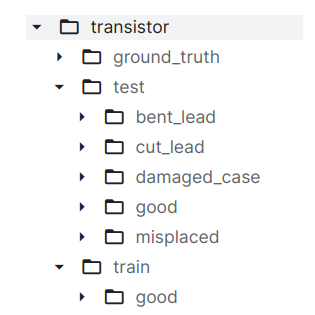

In the example above, `transistor` is the dataset root. It will contain a `train` folder and a `test` folder.

In the `train` folder, it only contains `good` folder. Inside of `good` folder, there are normal images (OK).

In the `test` folder, it contains `good` and other anomaly folders. Since, we don't care about these anomaly classes. We can specify only a `anomaly` folder, or whatever the name that you want. In short, `test` will contain `good` and `anomaly` folder. Inside of `good`, there are normal images. Inside of `anomaly` folder, there are abnormal (NG) images.

In [ ]:
import random
from random import sample
import argparse
import numpy as np
import os
import pickle
import glob
from tqdm import tqdm
from collections import OrderedDict
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.covariance import LedoitWolf
from scipy.spatial.distance import mahalanobis
from scipy.ndimage import gaussian_filter
from skimage import morphology
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import matplotlib
import torchvision
import pandas as pd
from PIL import Image
from dotmap import DotMap
import yaml
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision.models import wide_resnet50_2, resnet18, ResNet18_Weights, Wide_ResNet50_2_Weights
from torchvision import transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Import, define model

In [ ]:
def denormalization(x):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    x = (((x.transpose(1, 2, 0) * std) + mean) * 255.).astype(np.uint8)

    return x


def embedding_concat(x, y):
    B, C1, H1, W1 = x.size()
    _, C2, H2, W2 = y.size()
    s = int(H1 / H2)
    x = F.unfold(x, kernel_size=s, dilation=1, stride=s)
    x = x.view(B, C1, -1, H2, W2)
    z = torch.zeros(B, C1 + C2, x.size(2), H2, W2).to(x.device)
    for i in range(x.size(2)):
        z[:, :, i, :, :] = torch.cat((x[:, :, i, :, :], y), 1)
    z = z.view(B, -1, H2 * W2)
    z = F.fold(z, kernel_size=s, output_size=(H1, W1), stride=s)

    return z

#### Load train and test dataset

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, root, tfms=None):
        super(TrainDataset, self).__init__()
        self.tfms = transforms.Compose(
            [
                transforms.Resize([224, 224], Image.ANTIALIAS),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]
                )
            ]
        ) if tfms is None else tfms

        self.datas = self.read_data(root)

    def __getitem__(self, idx):
        img = Image.open(self.datas[idx]).convert('RGB')
        img = self.tfms(img)
        return img

    def __len__(self):
        return len(self.datas)

    def get_labels(self):
        return np.arange(len(self.datas)).tolist()

    def read_data(self, root):
        imgs = glob.glob(os.path.join(root, 'train', 'good', '*'))
        return imgs

class TestDataset(Dataset):
    def __init__(self, root, tfms=None):
        super(TestDataset, self).__init__()
        self.tfms = transforms.Compose(
            [
                transforms.Resize([224, 224], Image.ANTIALIAS),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]
                )
            ]
        ) if tfms is None else tfms

        self.datas = self.read_data(root)

    def __getitem__(self, idx):
        img = Image.open(self.datas[idx][0]).convert('RGB')
        img = self.tfms(img)
        label = self.datas[idx][1]
        return img, label

    def __len__(self):
        return len(self.datas)

    def read_data(self, root):
        ims, labels = [], []
        cls_idx = None
        for cls in os.listdir(os.path.join(root, 'test')):
            im_paths = sorted(glob.glob(os.path.join(root, 'test', cls, '*')))
            if cls == 'good': cls_idx = 0
            else: cls_idx = 1
            all_labels = [tuple([imp, cls_idx]) for imp in im_paths]
            ims.extend(all_labels)
            # if cls == 'good': labels.extend([0] * len(im_paths))
            # else: labels.extend([1] * len(im_paths))
        return ims

#### Padim

In [ ]:
class PaDiM():
    def __init__(self, args) -> None:
        self.input_size = (args.MODEL.INPUT_SIZE, args.MODEL.INPUT_SIZE)
        self.device = args.TRAIN.DEVICE
        self.save_dir = args.TRAIN.SAVE_DIR
        self.checkpoint_path = args.INFERENCE.CHECKPOINT_PATH

        if args.TRAIN.PRETRAINED:
            self.backbone = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).to(self.device)
        else:
            self.backbone = resnet18().to(self.device)

        self.t_d = 448
        # random pick features
        self.d = args.INFERENCE.REDUCE_FEATURES
        self.backbone.eval()
        self.idx = torch.tensor(sample(range(0, self.t_d), self.d)).to(self.device)

        self.output_layers = list()

        self.backbone.layer1[-1].register_forward_hook(self.hooks)
        self.backbone.layer2[-1].register_forward_hook(self.hooks)
        self.backbone.layer3[-1].register_forward_hook(self.hooks)

        self.distribution = None
        self.threshold = None
        self.max_score = None
        self.min_score = None

    def predict(self, data):
        '''
            data [torch.Tensor]: input data which has shape (batch, C, H, W)
                H, W    = (224, 224)
                C       = 3
                batch   = 1
        '''
        self.backbone.eval()

        outputs = OrderedDict([('layer1', []), ('layer2', []), ('layer3', [])])

        with torch.no_grad():
            _ = self.backbone(data.to(self.device))

        for k, v in zip(outputs.keys(), self.output_layers):
            outputs[k].append(v.detach())

        self.output_layers.clear()

        for k, v in outputs.items():
            outputs[k] = torch.cat(v, 0)

        # Embedding concat
        embedding_vectors = outputs['layer1']
        for layer_name in ['layer2', 'layer3']:
            embedding_vectors = embedding_concat(embedding_vectors, outputs[layer_name])

        # randomly select d dimension
        embedding_vectors = torch.index_select(embedding_vectors, 1, self.idx)
        # calculate distance matrix
        B, C, H, W = embedding_vectors.size()
        embedding_vectors = embedding_vectors.view(B, C, H * W)
        dist_list = []
        for i in range(H * W):
            mean = self.distribution[0][:, i]
            conv_inv = torch.linalg.inv(self.distribution[1][:, :, i])
            dist = [self.mahalanobis_torch(sample[:, i], mean, conv_inv) for sample in embedding_vectors]
            dist_list.append(dist)

        dist_list = torch.tensor(dist_list).transpose(1, 0).reshape(B, H, W)

        # upsample
        score_map = F.interpolate(dist_list.unsqueeze(1), size=data.size(2), mode='bilinear',
                                    align_corners=False).squeeze(1).numpy()

        # apply gaussian smoothing on the score map
        for i in range(score_map.shape[0]):
            score_map[i] = gaussian_filter(score_map[i], sigma=4)

        # Normalization
        # self.max_score = score_map.max()
        # self.min_score = score_map.min()
        scores = (score_map - self.min_score) / (self.max_score - self.min_score)

        return scores

    def train(self, dataloader):
        self.backbone.eval()
        train_outputs = OrderedDict([('layer1', []), ('layer2', []), ('layer3', [])])

        for img in dataloader:
            img = img.to(self.device)

            with torch.no_grad():
                _ = self.backbone(img)

            for k, v in zip(train_outputs.keys(), self.output_layers):
                train_outputs[k].append(v.detach())

            self.output_layers.clear()

        for k, v in train_outputs.items():
            train_outputs[k] = torch.cat(v, 0)

        # Embedding concat
        embedding_vectors = train_outputs['layer1']
        for layer_name in ['layer2', 'layer3']:
            embedding_vectors = embedding_concat(embedding_vectors, train_outputs[layer_name])

        # randomly select d dimension
        embedding_vectors = torch.index_select(embedding_vectors, 1, self.idx)
        # calculate multivariate Gaussian distribution
        B, C, H, W = embedding_vectors.size()
        embedding_vectors = embedding_vectors.view(B, C, H * W)
        mean = torch.mean(embedding_vectors, dim=0)
        cov = torch.zeros(C, C, H * W).to(self.device)
        I = torch.eye(C).to(self.device)
        for i in range(H * W):
            # cov[:, :, i] = LedoitWolf().fit(embedding_vectors[:, :, i].numpy()).covariance_
            cov[:, :, i] = torch.cov(embedding_vectors[:, :, i].T) + 0.01 * I
        # save learned distribution
        self.distribution = [mean, cov]

    def evaluate(self, dataloader):
        self.backbone.eval()
        test_outputs = OrderedDict([('layer1', []), ('layer2', []), ('layer3', [])])

        gt_list = list()

        for img, label in dataloader:
            img = img.to(self.device)

            with torch.no_grad():
                _ = self.backbone(img)

            for k, v in zip(test_outputs.keys(), self.output_layers):
                test_outputs[k].append(v.detach())

            gt_list.extend(label.cpu().detach().numpy())

            self.output_layers.clear()

        for k, v in test_outputs.items():
            test_outputs[k] = torch.cat(v, 0)

        # Embedding concat
        embedding_vectors = test_outputs['layer1']
        for layer_name in ['layer2', 'layer3']:
            embedding_vectors = embedding_concat(embedding_vectors, test_outputs[layer_name])

        # randomly select d dimension
        embedding_vectors = torch.index_select(embedding_vectors, 1, self.idx)
        # calculate distance matrix
        B, C, H, W = embedding_vectors.size()
        embedding_vectors = embedding_vectors.view(B, C, H * W)
        dist_list = []
        for i in range(H * W):
            mean = self.distribution[0][:, i]
            conv_inv = torch.linalg.inv(self.distribution[1][:, :, i])
            dist = [self.mahalanobis_torch(sample[:, i], mean, conv_inv) for sample in embedding_vectors]
            dist_list.append(dist)

        dist_list = torch.tensor(dist_list).transpose(1, 0).reshape(B, H, W)

        # upsample
        score_map = F.interpolate(dist_list.unsqueeze(1), size=self.input_size[0], mode='bilinear',
                                    align_corners=False).squeeze().numpy()

        # apply gaussian smoothing on the score map
        for i in range(score_map.shape[0]):
            score_map[i] = gaussian_filter(score_map[i], sigma=4)

        # Normalization
        self.max_score = score_map.max()
        self.min_score = score_map.min()
        scores = (score_map - self.min_score) / (self.max_score - self.min_score)

        # calculate image-level ROC AUC score
        img_scores = scores.reshape(scores.shape[0], -1).max(axis=1)
        gt_list = np.asarray(gt_list)
        img_roc_auc = roc_auc_score(gt_list, img_scores)
        # self.threshold = self.find_optimal_threshold(gt_list, img_scores)
        # print("Optimal threshold is:", self.threshold)
        return img_roc_auc

    def mahalanobis_torch(self, u, v, cov):
        delta = u - v
        m = torch.dot(delta, torch.matmul(cov, delta))
        return torch.sqrt(m)

    # def find_optimal_threshold(self, gt_list, img_scores):
    #     precision, recall, thresholds = precision_recall_curve(gt_list, img_scores)
    #     a = 2 * precision * recall
    #     b = precision + recall
    #     f1 = np.divide(a, b, out=np.zeros_like(a), where=b != 0)
    #     threshold = thresholds[np.argmax(f1)]
    #     return threshold

    def save_checkpoint(self, filename):
        ckp = {
            "max_score": self.max_score,
            "min_score": self.min_score,
            "threshold": self.threshold,
            "idx": self.idx,
            "dist": self.distribution
        }
        path = os.path.join(self.save_dir, filename)
        torch.save(ckp, path)
        # with open(path, 'wb') as f:
        #     pickle.dump(ckp, f)

    def load_checkpoint(self):
        # with open(self.checkpoint_path, 'rb') as f:
        #     ckp = pickle.load(f)
        ckp = torch.load(self.checkpoint_path, map_location=self.device)
        self.max_score = ckp['max_score']
        self.min_score = ckp['min_score']
        self.threshold = ckp['threshold']
        self.idx = ckp['idx']
        self.distribution = ckp['dist']

    def hooks(self, module, input, output):
        self.output_layers.append(output)

### Config

INPUT_SIZE: size of image data

EPOCH: number of epoch

BATCH_SIZE: number of batchsize

PRETRAINED (bool): use pretrained vgg to extract features

DEVICE: "cpu" or "cuda"

DATA_DIR: path to your dataset

SAVE_DIR: path of directory to save checkpoint file (weight file)

CHECKPOINT_PATH: path to checkpoint file so model can load and run inference

REDUCE_FEATURE: reduce number of features to this number

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%writefile /content/config.yaml
MODEL:
  INPUT_SIZE: 224
TRAIN:
  EPOCH: 5
  BATCH_SIZE: 16
  PRETRAINED: True
  DEVICE: "cpu"


  DATA_DIR: "/content/drive/MyDrive/hazelnut"
  SAVE_DIR: "/content/drive/MyDrive/hazelnut"
  SAVE_DIR: "/content"




INFERENCE:
  CHECKPOINT_PATH: "/content/train_transistor_.pt"
  REDUCE_FEATURES: 100

Writing /content/config.yaml


In [ ]:
def read_args(filename):
    with open(filename) as f:
        cf = yaml.safe_load(f)
    f.close()
    args = DotMap(cf)
    return args

args = read_args("/content/config.yaml")

In [ ]:
tfms = transforms.Compose(
            [
                transforms.Resize([224, 224], Image.ANTIALIAS),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]
                )
            ]
)

train_set = TrainDataset(root=args.TRAIN.DATA_DIR, tfms=tfms)
test_set = TestDataset(root=args.TRAIN.DATA_DIR, tfms=tfms)

train_dl = DataLoader(train_set, batch_size=args.TRAIN.BATCH_SIZE, num_workers=os.cpu_count(),
                      shuffle=True, pin_memory=True, drop_last=False)

test_dl = DataLoader(test_set, batch_size=args.TRAIN.BATCH_SIZE, num_workers=os.cpu_count(),
                     shuffle=False, pin_memory=True)

print('Size of training set: ', len(train_set))
print('Size of testing set: ', len(test_set))  # solo deje damaged case

Size of training set:  300
Size of testing set:  162


In [ ]:
model = PaDiM(args)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 65.5MB/s]


In [ ]:
# train y salva modelo entrenado como train_transistor_.pt
model.train(train_dl)

# test
roc_auc = model.evaluate(test_dl)

print("ROC AUC score:", roc_auc)

#model.save_checkpoint(filename=f'train_transistor_{roc_auc:.2f}.pt')  # train_transistor_0.92.pt

model.save_checkpoint(filename=f'train_transistor_.pt')  # train_transistor_.pt  roc_auc agnostico.
# /content/drive/MyDrive/transistor/train_transistor_.pt

print('Max score:', model.max_score, 'Min score', model.min_score)

ROC AUC score: 0.7666615830410248
Max score: 31.810404 Min score 0.1631401


### Test

In [ ]:
test_model = PaDiM(args)
test_model.load_checkpoint()

Anomaly:  True


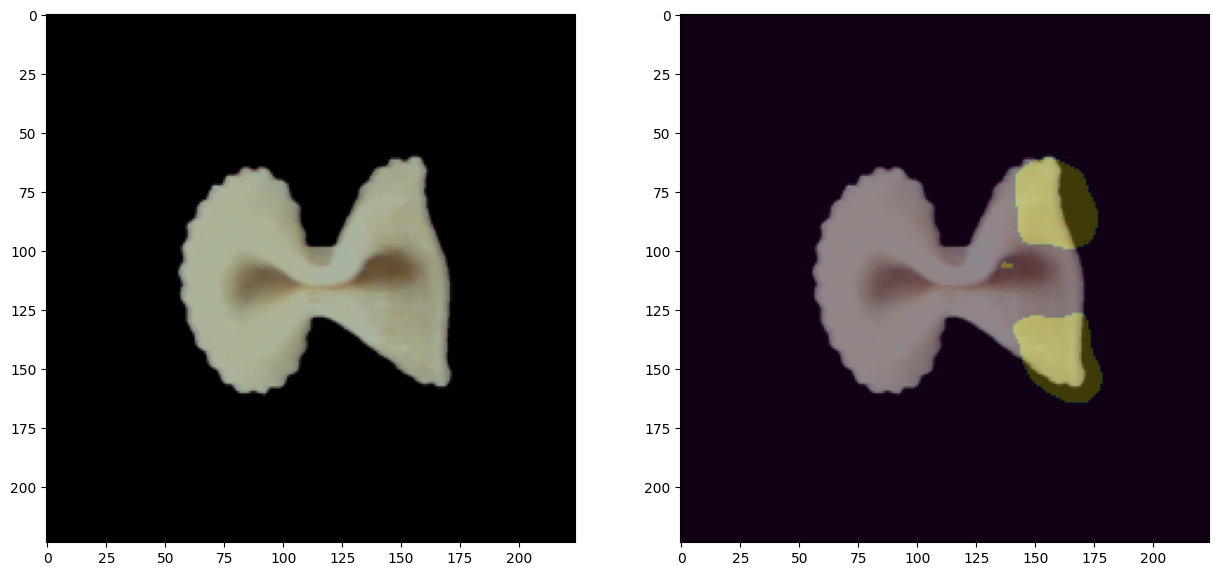

In [ ]:
threshold = 0.4

path = '/content/drive/MyDrive/hazelnut/test/bad/0 (28).PNG'

infer_tfms = transforms.Compose(
            [
                transforms.Resize([224, 224]),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]
                )
            ]
)

img_ = Image.open(path).convert('RGB')
img = tfms(img_)
img = img.unsqueeze(0)

scores = test_model.predict(img)

pred = np.any(scores > threshold)
print("Anomaly: ", pred)

mask = np.where(scores > threshold, 1, 0)

vis_img = img_.resize((224, 224))

f, axarr = plt.subplots(1,2, figsize=(15, 15))
axarr[0].imshow(vis_img)
axarr[1].imshow(mask.squeeze(0))
axarr[1].imshow(vis_img, alpha = 0.75)
# axarr[2].imshow(true_mask)
plt.show()

In [ ]:
!python --version

Python 3.10.12
